In [1]:
# Preprocessing isbi 2012 dataset tiff to png
import tensorflow as tf
import tifffile as tiff
import skimage.io as io
import os
import torch
import torch.nn as nn
from absl import flags
from absl import app
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from keras.preprocessing.image import ImageDataGenerator


In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

dir_data = '/content/drive/MyDrive/UNET-tf2-main/UNET-tf2-main/isbi_2012/raw_data'

name_label = 'train-labels.tif'
name_input = 'train-volume.tif'

img_label = Image.open(os.path.join(dir_data, name_label))
img_input = Image.open(os.path.join(dir_data, name_input))

nx, ny = img_label.size
nframe = img_label.n_frames

print("nx = " ,nx)
print("ny = " ,ny)
print("nframe = ", nframe)

nx =  512
ny =  512
nframe =  30


In [3]:
nframe_train = 24
nframe_val = 3
nframe_test = 3

dir_save_train = os.path.join(dir_data, 'train')
dir_save_val = os.path.join(dir_data, 'val')
dir_save_test = os.path.join(dir_data, 'test')

# 디렉토리 생성
if not os.path.exists(dir_save_train):
  os.makedirs(dir_save_train)

if not os.path.exists(dir_save_val):
  os.makedirs(dir_save_val)

if not os.path.exists(dir_save_test):
  os.makedirs(dir_save_test)

In [4]:
id_frame = np.arange(nframe)
np.random.shuffle(id_frame)
print(id_frame)

[14 27 13 22 11 19 26  5  3 17 18  2  7 20 24 25  0  6  8 16 15 21 28 10
  1 29 12 23  9  4]


In [5]:
# 셔플된 프레임 저장
offset_nframe  =0
for i in range(nframe_train):
  img_label.seek(id_frame[i + offset_nframe])
  img_input.seek(id_frame[i + offset_nframe])

  label_ = np.asarray(img_label)
  input_ = np.asarray(img_input)
  print("label_ =",label_)
  print("input_ =",input_)
  print("=" *100)
  np.save(os.path.join(dir_save_train, 'label_%03d.npy' % i), label_)
  np.save(os.path.join(dir_save_train, 'input_%03d.npy' % i), input_)

label_ = [[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]]
input_ = [[201 194 175 ...  85  76  76]
 [183 172 164 ... 130  81  48]
 [159 157 171 ... 146  93  64]
 ...
 [166 129  92 ... 104  87  98]
 [140 105  83 ... 108  81  90]
 [109  88  80 ... 115 102 101]]
label_ = [[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
input_ = [[ 95 105  53 ... 178 155 186]
 [101 131  62 ... 163 137 160]
 [117 151  99 ... 149 137 151]
 ...
 [173 156 103 ... 157 158 132]
 [184 193 176 ... 128  89  76]
 [152 172 157 ... 146  92  73]]
label_ = [[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [  0   0   0 ... 255 255 255]
 [255   0   0 ... 255 255 255]
 [255 255 255 ... 255 255 2

In [6]:
# 셔플된 프레임 저장
offset_nframe  += nframe_val
for i in range(nframe_test):
  img_label.seek(id_frame[i + offset_nframe])
  img_input.seek(id_frame[i + offset_nframe])

  label_ = np.asarray(img_label)
  input_ = np.asarray(img_input)

  np.save(os.path.join(dir_save_test, 'label_%03d.npy' % i), label_)
  np.save(os.path.join(dir_save_test, 'input_%03d.npy' % i), input_)

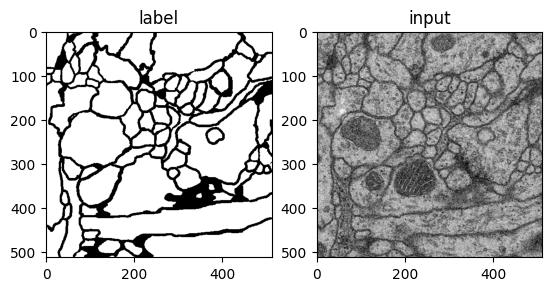

In [7]:
plt.subplot(121)
plt.imshow(label_, cmap ='gray')
plt.title('label')

plt.subplot(122)
plt.imshow(input_, cmap ='gray')
plt.title('input')
plt.show()


In [8]:
# U-Net Model
class UNet_ISBI(nn.Module):
    def __init__(self):
        super(UNet_ISBI, self).__init__()

        def DoubleConv(in_channels, out_channels, kernel_size=3):
            layer = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(),
                nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU()
            )

            return layer

        # Contracting part
        self.conv1 = DoubleConv(1, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = DoubleConv(256, 512)
        self.drop4 = nn.Dropout(0.5)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv5 = DoubleConv(512, 1024)
        self.drop5 = nn.Dropout(0.5)

        # Expansive part
        self.up6 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)
        self.conv6 = DoubleConv(1024, 512)
        self.up7 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
        self.conv7 = DoubleConv(512, 256)
        self.up8 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.conv8 = DoubleConv(256, 128)
        self.up9 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.conv9 = DoubleConv(128, 64)

        self.fc = nn.Conv2d(64, 1, kernel_size=1, stride=1)

    def forward(self, x):
        layer1 = self.conv1(x)
        out = self.pool1(layer1)
        layer2 = self.conv2(out)
        out = self.pool2(layer2)
        layer3 = self.conv3(out)
        out = self.pool3(layer3)
        layer4 = self.conv4(out)
        drop = self.drop4(layer4)
        out = self.pool4(drop)
        layer5 = self.conv5(out)
        drop = self.drop5(layer5)

        up = self.up6(drop)
        cat1 = torch.cat((transforms.CenterCrop((up.shape[2], up.shape[3]))(layer4), up), dim=1)
        layer6 = self.conv6(cat1)
        up = self.up7(layer6)
        cat2 = torch.cat((transforms.CenterCrop((up.shape[2], up.shape[3]))(layer3), up), dim=1)
        layer7 = self.conv7(cat2)
        up = self.up8(layer7)
        cat3 = torch.cat((transforms.CenterCrop((up.shape[2], up.shape[3]))(layer2), up), dim=1)
        layer8 = self.conv8(cat3)
        up = self.up9(layer8)
        cat4 = torch.cat((transforms.CenterCrop((up.shape[2], up.shape[3]))(layer1), up), dim=1)
        layer9 = self.conv9(cat4)

        out = self.fc(layer9)
        return out


In [ ]:
import torchsummary

unet_model = UNet_ISBI()
torchsummary.summary(unet_model, (1, 572, 572))

In [9]:
 # 파라미터 설정
 lr = 1e-4
 batch_size = 4
 # num_epoch =100
 num_epoch = 10

 data_dir = '/content/drive/MyDrive/UNET-tf2-main/UNET-tf2-main/isbi_2012/raw_data'
 ckpt_dir = '/content/ckeckpoint'
 log_dir = '/content/log'


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [11]:
import os
import numpy as np

import torch
import torch.nn as nn

# reference : https://sd118687.tistory.com/11?category=549654
# tensor shape (1, x, y)
def mirroring_Extrapolate(img):
    # mirroring 92 pixel
    img = torch.from_numpy(img.transpose((2, 0, 1)))

    x = img.shape[1]
    y = img.shape[2]

    np_img = np.array(img)

    np_img = np_img[0]

    if x < 388:
        pad_x_left = (572 - x) / 2
        pad_x_right = (572 - x) / 2
    else:
        pad_x_left = 92
        pad_x_right = 388 - (x % 388) + 92

    if y < 388:
        pad_y_up = (572 - y) / 2
        pad_y_down = (572 - y) / 2
    else:
        pad_y_up = 92
        pad_y_down = 388 - (y % 388) + 92

    np_img = np.pad(np_img, ((pad_x_left, pad_x_right), (pad_y_up, pad_y_down)), 'reflect')

    np_img = np_img[:, :, np.newaxis]

    return np_img


class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        lst_data = os.listdir(self.data_dir)

        lst_label = [f for f in lst_data if f.startswith('label')]
        lst_input = [f for f in lst_data if f.startswith('input')]

        lst_label.sort()
        lst_input.sort()

        self.lst_label = lst_label
        self.lst_input = lst_input

    def __len__(self):
        return len(self.lst_label)

    def __getitem__(self, index):
        label = np.load(os.path.join(self.data_dir, self.lst_label[index]))
        input = np.load(os.path.join(self.data_dir, self.lst_input[index]))
        label = label/255.0
        input = input/255.0

        #채널이 없는 경우 늘리기
        if label.ndim == 2:
            label = label[:, :, np.newaxis]
        if input.ndim == 2:
            input = input[:, :, np.newaxis]

        label = mirroring_Extrapolate(label)
        input = mirroring_Extrapolate(input)


        data = {'input' : input, 'label' : label}

        if self.transform:
            data = self.transform(data)

        return data



In [12]:
# 데이터로더 확인
dataset_train = Dataset(data_dir = os.path.join(data_dir, 'train'))

In [13]:
data = dataset_train.__getitem__(0)

input = data['input']
label = data['label']

In [14]:
test = torch.from_numpy(input.transpose((2, 0, 1)))
print(test.shape)

torch.Size([1, 960, 960])


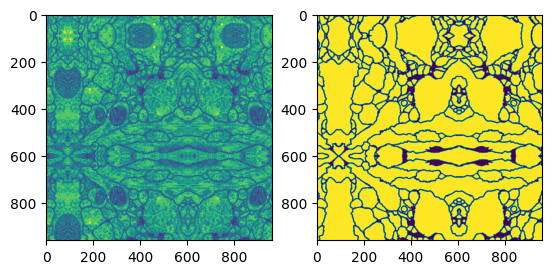

In [15]:
# squeeze()를 사용해 channel처리후 시각화
plt.subplot(121)
plt.imshow(input.squeeze())
plt.subplot(122)
plt.imshow(label.squeeze())
plt.show()


In [16]:
# 트랜스폼

# numpy to tensor
class ToTensor(object):
    def __call__(self, data):

        # image numpy 차원 = (y,x, channel)
        # image tensor 차원 = (channel , y, x)
        label, input = data['label'], data['input']

        label = label.transpose((2, 0, 1)).astype(np.float32)
        input = input.transpose((2, 0, 1)).astype(np.float32)

        data = {'label' : torch.from_numpy(label),
                'input' : torch.from_numpy(input)}

        return data

class Normalization(object):
    def __init__(self, mean=0.5, std=0.5):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        label, input = data['label'], data['input']

        input = (input - self.mean) / self.std
        data = {'label' : label,
                'input' : input}

        return data

class RandomFlip(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        if np.random.rand() > 0.5:
            label = np.fliplr(label)
            input = np.fliplr(input)
        if np.random.rand() > 0.5:
            label = np.flipud(label)
            input = np.flipud(input)

        data = {'label' : label, 'input' : input}
        return data


In [17]:
from torch.utils.data.dataloader import DataLoader
# 트랜스폼
transform = transforms.Compose([Normalization(mean=0.5, std=0.5),
                                RandomFlip(),
                                ToTensor()])

# dataset_train
dataset_train = Dataset(data_dir = os.path.join(data_dir, 'train'), transform=transform)
loader_train = DataLoader(dataset_train, batch_size = batch_size, shuffle = True, num_workers = 8)

dataset_val = Dataset(data_dir = os.path.join(data_dir, 'val'), transform=transform)
loader_val = DataLoader(dataset_val, batch_size = batch_size, shuffle = False, num_workers = 8)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [18]:
!pip install tensorboardX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.0 MB/s eta 0:00:00


In [19]:
from tensorboardX import SummaryWriter

net = UNet_ISBI().to(device)

fn_loss = nn.BCEWithLogitsLoss().to(device)

optim = torch.optim.Adam(net.parameters(), lr=lr)

num_data_train = len(dataset_train)
num_data_val = len(dataset_val)

num_batch_train = np.ceil(num_data_train / batch_size)
num_batch_val = np.ceil(num_data_val / batch_size)

# output을 저장하기 위한 함수

# tensor to numpy
fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)

# norm to denorm
fn_denorm = lambda x, mean, std: (x * std) + mean

# network output을 binary로 분류
fn_class = lambda x: 1.0 * (x > 0.5)

## Tensorboard 를 사용하기 위한 SummaryWriter 설정
writer_train = SummaryWriter(log_dir=os.path.join(log_dir, 'train'))
writer_val = SummaryWriter(log_dir=os.path.join(log_dir, 'val'))

In [20]:
# 네트워크 저장
def save(ckpt_dir, net, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'net' : net.state_dict(), 'optim': optim.state_dict()},
               "%s/model_epoch%d.pth" % (ckpt_dir, epoch))

## 네트워크 불러오기
def load(ckpt_dir, net, optim):
    if not os.path.exists(ckpt_dir):
        epoch = 0
        return net, optim, epoch

    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

    dict_model = torch.load('%s/%s' % (ckpt_dir, ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])
    epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pth')[0])

    return net, optim,

In [21]:
import torchvision
# reference : https://sd118687.tistory.com/11?category=549654

# input : 960 x 960 / output 572 x 572 4개
def divide_input(img):
    left_top = torchvision.transforms.functional.crop(img, 0, 0, 572, 572)
    right_top = torchvision.transforms.functional.crop(img, 388, 0, 572, 572)
    left_bottom = torchvision.transforms.functional.crop(img, 0, 388, 572, 572)
    right_bottom = torchvision.transforms.functional.crop(img, 388, 388, 572, 572)
    return left_top, right_top, left_bottom, right_bottom

# input : 960 x 960 / output 388 x 388 4개
def divide_label(img):
    left_top = torchvision.transforms.functional.crop(img, 92, 92, 388, 388)
    right_top = torchvision.transforms.functional.crop(img, 480, 92, 388, 388)
    left_bottom = torchvision.transforms.functional.crop(img, 92, 480, 388, 388)
    right_bottom = torchvision.transforms.functional.crop(img, 480, 480, 388, 388)
    return left_top, right_top, left_bottom, right_bottom

epoch :  1
Train : Epoch 0001 / 0010 | Batch 0001 / 0006 | Loss 0.8316
Train : Epoch 0001 / 0010 | Batch 0001 / 0006 | Loss 0.8058
Train : Epoch 0001 / 0010 | Batch 0001 / 0006 | Loss 0.7893
Train : Epoch 0001 / 0010 | Batch 0001 / 0006 | Loss 0.7788
Train : Epoch 0001 / 0010 | Batch 0002 / 0006 | Loss 0.7673
Train : Epoch 0001 / 0010 | Batch 0002 / 0006 | Loss 0.7548
Train : Epoch 0001 / 0010 | Batch 0002 / 0006 | Loss 0.7470
Train : Epoch 0001 / 0010 | Batch 0002 / 0006 | Loss 0.7362
Train : Epoch 0001 / 0010 | Batch 0003 / 0006 | Loss 0.7248
Train : Epoch 0001 / 0010 | Batch 0003 / 0006 | Loss 0.7140
Train : Epoch 0001 / 0010 | Batch 0003 / 0006 | Loss 0.7035
Train : Epoch 0001 / 0010 | Batch 0003 / 0006 | Loss 0.6923
Train : Epoch 0001 / 0010 | Batch 0004 / 0006 | Loss 0.6849
Train : Epoch 0001 / 0010 | Batch 0004 / 0006 | Loss 0.6764
Train : Epoch 0001 / 0010 | Batch 0004 / 0006 | Loss 0.6690
Train : Epoch 0001 / 0010 | Batch 0004 / 0006 | Loss 0.6614
Train : Epoch 0001 / 0010 | B

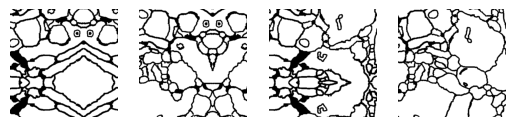

Train : Epoch 0010 / 0010 | Batch 0001 / 0006 | Loss 0.3228
Train : Epoch 0010 / 0010 | Batch 0001 / 0006 | Loss 0.3163
Train : Epoch 0010 / 0010 | Batch 0001 / 0006 | Loss 0.3150
Train : Epoch 0010 / 0010 | Batch 0001 / 0006 | Loss 0.3128


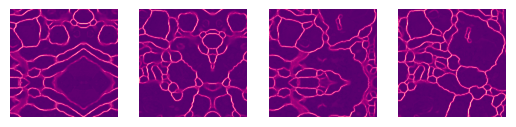

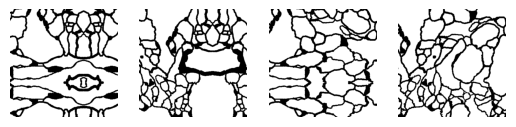

Train : Epoch 0010 / 0010 | Batch 0002 / 0006 | Loss 0.3104
Train : Epoch 0010 / 0010 | Batch 0002 / 0006 | Loss 0.3115
Train : Epoch 0010 / 0010 | Batch 0002 / 0006 | Loss 0.3102
Train : Epoch 0010 / 0010 | Batch 0002 / 0006 | Loss 0.3100


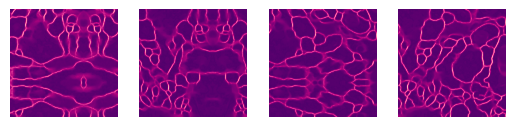

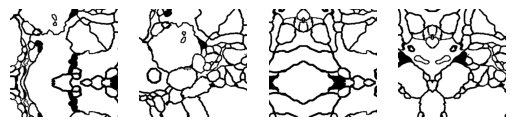

Train : Epoch 0010 / 0010 | Batch 0003 / 0006 | Loss 0.3084
Train : Epoch 0010 / 0010 | Batch 0003 / 0006 | Loss 0.3066
Train : Epoch 0010 / 0010 | Batch 0003 / 0006 | Loss 0.3061
Train : Epoch 0010 / 0010 | Batch 0003 / 0006 | Loss 0.3048


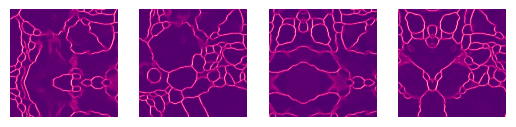

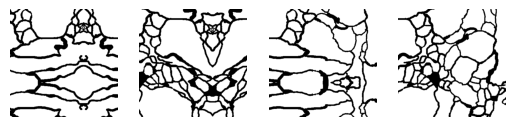

Train : Epoch 0010 / 0010 | Batch 0004 / 0006 | Loss 0.3043
Train : Epoch 0010 / 0010 | Batch 0004 / 0006 | Loss 0.3033
Train : Epoch 0010 / 0010 | Batch 0004 / 0006 | Loss 0.3032
Train : Epoch 0010 / 0010 | Batch 0004 / 0006 | Loss 0.3025


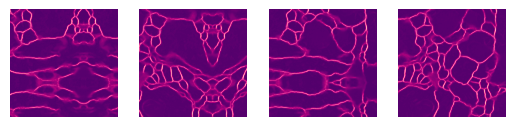

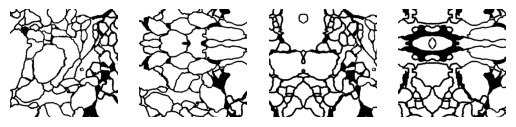

Train : Epoch 0010 / 0010 | Batch 0005 / 0006 | Loss 0.3018
Train : Epoch 0010 / 0010 | Batch 0005 / 0006 | Loss 0.3020
Train : Epoch 0010 / 0010 | Batch 0005 / 0006 | Loss 0.3015
Train : Epoch 0010 / 0010 | Batch 0005 / 0006 | Loss 0.3019


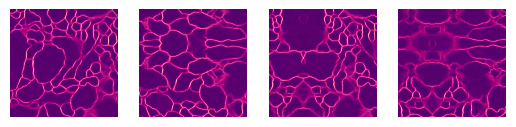

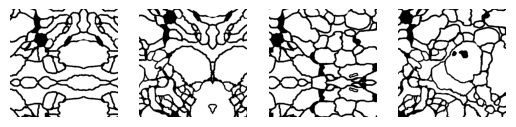

Train : Epoch 0010 / 0010 | Batch 0006 / 0006 | Loss 0.3014
Train : Epoch 0010 / 0010 | Batch 0006 / 0006 | Loss 0.3015
Train : Epoch 0010 / 0010 | Batch 0006 / 0006 | Loss 0.3017
Train : Epoch 0010 / 0010 | Batch 0006 / 0006 | Loss 0.3016


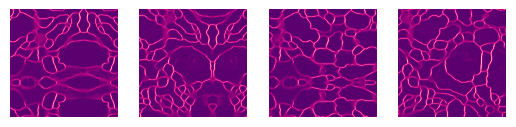

In [22]:
net, optim, st_epoch = load(ckpt_dir = ckpt_dir, net=net, optim=optim)

# Training
st_epoch = 0
for epoch in range(st_epoch + 1, num_epoch + 1):
    net.train()
    loss_arr = []
    print('epoch : ', epoch)

    for batch, data in enumerate(loader_train, 1):
        # forward pass
        label = data['label'].to(device)
        input = data['input'].to(device)


        input_0, input_1, input_2, input_3 = divide_input(input)
        label_0, label_1, label_2, label_3 = divide_label(label)

        input_list = []
        label_list = []

        input_list.append(input_0)
        input_list.append(input_1)
        input_list.append(input_2)
        input_list.append(input_3)

        label_list.append(label_0)
        label_list.append(label_1)
        label_list.append(label_2)
        label_list.append(label_3)

        if(epoch==10):
            for c in range(4):
                # https://discuss.pytorch.org/t/plot-4d-tensor-as-image/147566/2
                plt.subplot(1,4,c+1)
                label_img = label_list[c].cpu()[0]
                label_img = label_img.permute(1, 2, 0).numpy()
                plt.imshow(label_img, cmap ='gray')
                plt.axis('off')
            plt.show()

        for i in range(4):
            # print('input shape : ', input_list[i].shape) -> input shape :  torch.Size([4, 1, 572, 572]) which is [batch_size, channels, height, width]
            # print('label shape : ', label_list[i].shape) -> label shape :  torch.Size([4, 1, 388, 388])
            output = net(input_list[i])

            if(epoch==10):
                plt.subplot(1,4,i+1)
                output_img = output.cpu()[0]
                output_img = output_img.permute(1, 2, 0).detach().numpy()
                plt.imshow(output_img, cmap ='RdPu')
                plt.axis('off')


            # print('output shape : ', output.shape) -> output shape :  torch.Size([4, 1, 388, 388])

            # backward pass
            optim.zero_grad()

            loss = fn_loss(output, label_list[i])
            loss.backward()
            optim.step()


            # Loss
            loss_arr += [loss.item()]
            print("Train : Epoch %04d / %04d | Batch %04d / %04d | Loss %.4f"% (epoch, num_epoch, batch, num_batch_train, np.mean(loss_arr)))



            # 텐서보드에 저장
            #label = fn_tonumpy(label)
            #input = fn_tonumpy(fn_denorm(input, mean = 0.5, std = 0.5))
            #output = fn_tonumpy(fn_class(output))

            #writer_train.add_image('label', label, num_batch_train * (epoch -1) + batch, dataformats ='NHWC')
            #writer_train.add_image('input', input, num_batch_train * (epoch -1) + batch, dataformats ='NHWC')
            #writer_train.add_image('output', output, num_batch_train * (epoch -1) + batch, dataformats ='NHWC')
    #writer_train.add_scalar('loss', np.mean(loss_arr), epoch)
        plt.show()

    # validation
    with torch.no_grad():
        net.eval()
        loss_arr = []
        for batch, data in enumerate(loader_val, 1):

            # forward pass
            label = data['label'].to(device)
            input = data['input'].to(device)

            input_0, input_1, input_2, input_3 = divide_input(input)
            label_0, label_1, label_2, label_3 = divide_label(label)

            input_list = []
            label_list = []

            input_list.append(input_0)
            input_list.append(input_1)
            input_list.append(input_2)
            input_list.append(input_3)

            label_list.append(label_0)
            label_list.append(label_1)
            label_list.append(label_2)
            label_list.append(label_3)


            for i in range(4):
                output = net(input)

                # Loss
                loss = fn_loss(output, label)
                loss_arr += [loss.item()]
                print("Val : Epoch %04d / %04d | Batch %04d / %04d | Loss %.4f"% (epoch, num_epoch, batch, num_batch_train, np.mean(loss_arr)))

                #label = fn_tonumpy(label)
                #input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
                #output = fn_tonumpy(fn_class(output))
                #writer_val.add_image('label', label, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')
                #writer_val.add_image('input', input, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')
                #writer_val.add_image('output', output, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')

    #writer_val.add_scalar('loss', np.mean(loss_arr), epoch)
    if epoch % 5 == 0:
        save(ckpt_dir = ckpt_dir, net = net, optim= optim, epoch = epoch)
#writer_train.close()
#writer_val.close()


